In [1]:
import dask
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt

from datetime import datetime
from matplotlib.ticker import FormatStrFormatter

dask.config.set(scheduler = "single-threaded")

In [2]:
# Load data sets
# --------------------------------------

ds1 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpdlprofwind4newsC1.c1.*.nc',   combine='by_coords', parallel = True)
ds2 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flxwindC1.b1.*.nc',        combine='by_coords', parallel = True)
ds3 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpinterpolatedsondeC1.c1.*.nc', combine='by_coords', parallel = True)
ds4 = xr.open_mfdataset('/Users/smata/Downloads/processedData/sgpco2flx60mC1.b1.*.nc',         combine='by_coords', parallel = True)

In [3]:
# Get reference dates from each data set
# --------------------------------------

ref_date1 = np.datetime64(datetime(pd.to_datetime(ds1.time[0].values).year, pd.to_datetime(ds1.time[0].values).month, pd.to_datetime(ds1.time[0].values).day))
ref_date2 = np.datetime64(datetime(pd.to_datetime(ds2.time[0].values).year, pd.to_datetime(ds2.time[0].values).month, pd.to_datetime(ds2.time[0].values).day))
ref_date3 = np.datetime64(datetime(pd.to_datetime(ds3.time[0].values).year, pd.to_datetime(ds3.time[0].values).month, pd.to_datetime(ds3.time[0].values).day))
ref_date4 = np.datetime64(datetime(pd.to_datetime(ds4.time[0].values).year, pd.to_datetime(ds4.time[0].values).month, pd.to_datetime(ds4.time[0].values).day))

In [4]:
# Ensure reference dates match
# --------------------------------------

assert(ref_date1 == ref_date2)
assert(ref_date1 == ref_date3)
assert(ref_date1 == ref_date4)

In [5]:
# Compute new time axis
# --------------------------------------

ds1['time'] = ((ds1.time - ref_date1) / np.timedelta64(1, 'D')).values
ds2['time'] = ((ds2.time - ref_date2) / np.timedelta64(1, 'D')).values
ds3['time'] = ((ds3.time - ref_date3) / np.timedelta64(1, 'D')).values
ds4['time'] = ((ds4.time - ref_date4) / np.timedelta64(1, 'D')).values

In [6]:
# Get interpolation values
# --------------------------------------

min_date = max([ds1['time'][0],  ds2['time'][0],  ds3['time'][0],  ds4['time'][0]])
max_date = min([ds1['time'][-1], ds2['time'][-1], ds3['time'][-1], ds4['time'][-1]])

interval = (1 / 12) / 24

common_time = np.arange(min_date, max_date, interval)

In [7]:
# Regularize data sets
# --------------------------------------

ds1 = ds1.interp(time = common_time)
ds2 = ds2.interp(time = common_time)
ds3 = ds3.interp(time = common_time, height = 3000)
ds4 = ds4.interp(time = common_time)

ds_combined = xr.concat([ds2, ds1, ds3], dim = 'height')
ds_combined = ds_combined.sortby('height')

old_u = ds_combined['u'].values
old_v = ds_combined['v'].values

heights     = np.concatenate(([4], [10], np.arange(20, 2000 + 20, 20)))
old_heights = ds_combined['height'].values
new_u       = np.zeros((len(heights), ds_combined['u'].shape[1]))
new_v       = np.zeros((len(heights), ds_combined['v'].shape[1]))

# Interpolate to regularized heights
for t in range(new_u.shape[1]):
    inds = ~np.isnan(old_u[:, t])
    if any(inds == True):
        new_u[:,t] = np.interp(heights, old_heights[inds], old_u[inds, t])
        new_v[:,t] = np.interp(heights, old_heights[inds], old_v[inds, t])

qc_flag_w = np.zeros(common_time.shape)
qc_flag_s = np.zeros(common_time.shape)

total_h = len(old_heights)

surface_quantity = ds4.L.values

# Count nans in each data set
for t in range(common_time.shape[0]):
    qc_flag_w[t] = np.sum(np.isnan(old_u[:, t])) / total_h
    qc_flag_s[t] = ~np.isnan(surface_quantity[t])

# Nan threshold for spatial data
qc_flag_w = qc_flag_w < 2 / 3

qc_flag = qc_flag_w * (qc_flag_s).astype(bool)

del ds1
del ds2
del ds3
del old_u
del old_v

# Store QC'ed data in new structure
ds_new = xr.Dataset({
'u': xr.DataArray(
            data   = new_u[:, qc_flag],
            dims   = ['height', 'time'],
            coords = {'height': heights, 'time': common_time[qc_flag]},
),
'v': xr.DataArray(
            data   = new_v[:, qc_flag],
            dims   = ['height', 'time'],
            coords = {'height': heights, 'time': common_time[qc_flag]},
),
'L': xr.DataArray(
            data   = 1 / (ds4.L.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'TKE': xr.DataArray(
            data   = (ds4.TKE.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'hFlux': xr.DataArray(
            data   = (ds4.sh_flux.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
'mFlux': xr.DataArray(
            data   = (ds4.mom_flux.values)[qc_flag],
            dims   = ['time'],
            coords = {'time': common_time[qc_flag]},
),
    })

# Average over 60min windows

ds_new = ds_new.assign_coords(time = pd.Timestamp(ref_date1) + pd.to_timedelta(ds_new.time, unit = 'D').round('min'))

ds_new = ds_new.resample(time = '1h').mean(dim = ['time'])

ds_new['time'] = ((ds_new.time - ref_date1) / np.timedelta64(1, 'D')).values

ds_new = ds_new.dropna(dim = 'time', how = 'all')

ds_new = ds_new.transpose()

del ds_combined
del ds4
del new_u
del new_v

/Users/smata/miniconda3/envs/vscode_env/lib/python3.12/site-packages/xarray/core/groupby.py:508: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index_grouper = pd.Grouper(


(0.0, 2000.0)

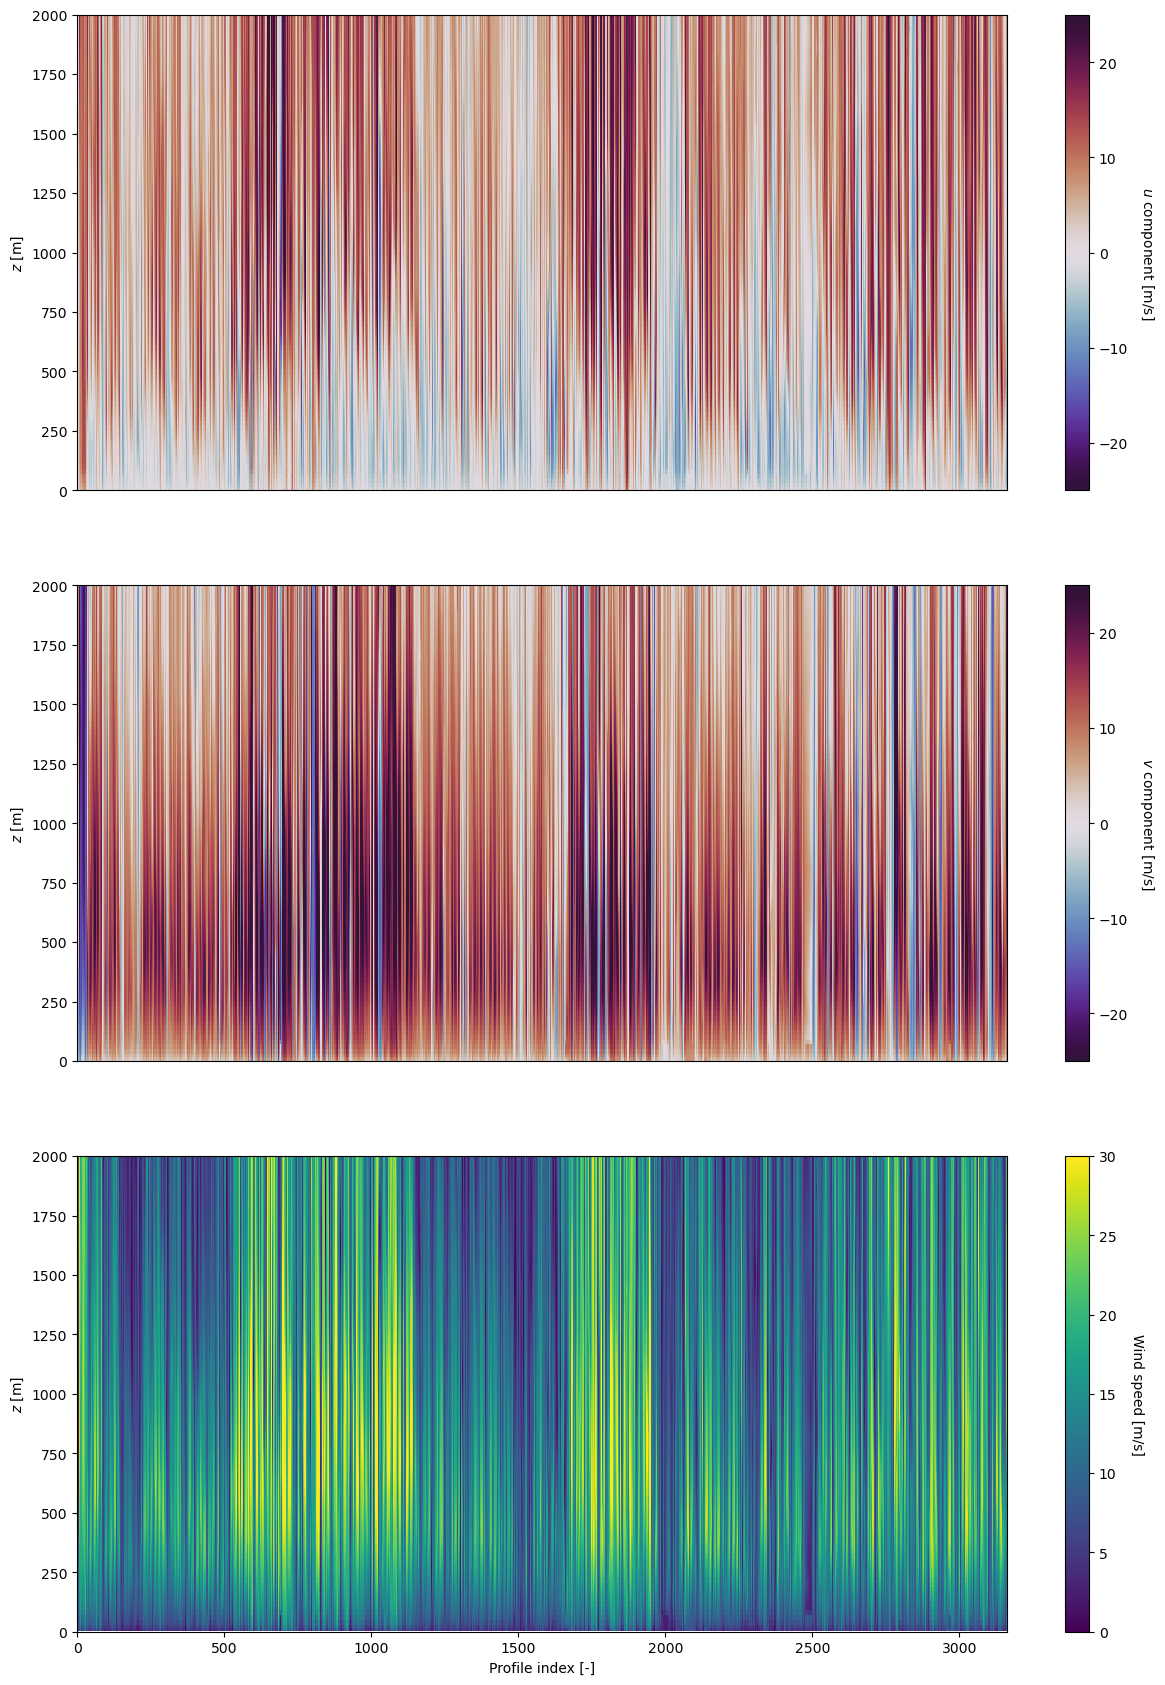

In [11]:
# Plot rectified wind profiles
# --------------------------------------

x_axis = range(len(ds_new.time))

fig,ax = plt.subplots(3, 1, figsize = (15, 21))

cntf = ax[0].pcolormesh(x_axis, ds_new.height, ds_new.u, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$u$ component [m/s]', rotation = 270, labelpad = 20)
ax[0].set_ylabel("$z$ [m]")
ax[0].set_ylim([0, 2000])
ax[0].get_xaxis().set_ticks([])

cntf = ax[1].pcolormesh(x_axis, ds_new.height, ds_new.v, vmin = -25, vmax = 25, cmap = 'twilight_shifted')
cbar = plt.colorbar(cntf)
cbar.set_label('$v$ component [m/s]', rotation = 270, labelpad = 20)
ax[1].set_ylabel("$z$ [m]")
ax[1].set_ylim([0, 2000])
ax[1].get_xaxis().set_ticks([])

cntf = ax[2].pcolormesh(x_axis, ds_new.height, (ds_new.v**2 + ds_new.u**2)**(1 / 2), vmin = 0, vmax = 30, cmap = 'viridis')
cbar = plt.colorbar(cntf)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 20)
ax[2].set_xlabel("Profile index [-]")
ax[2].set_ylabel("$z$ [m]")
ax[2].set_ylim([0, 2000])

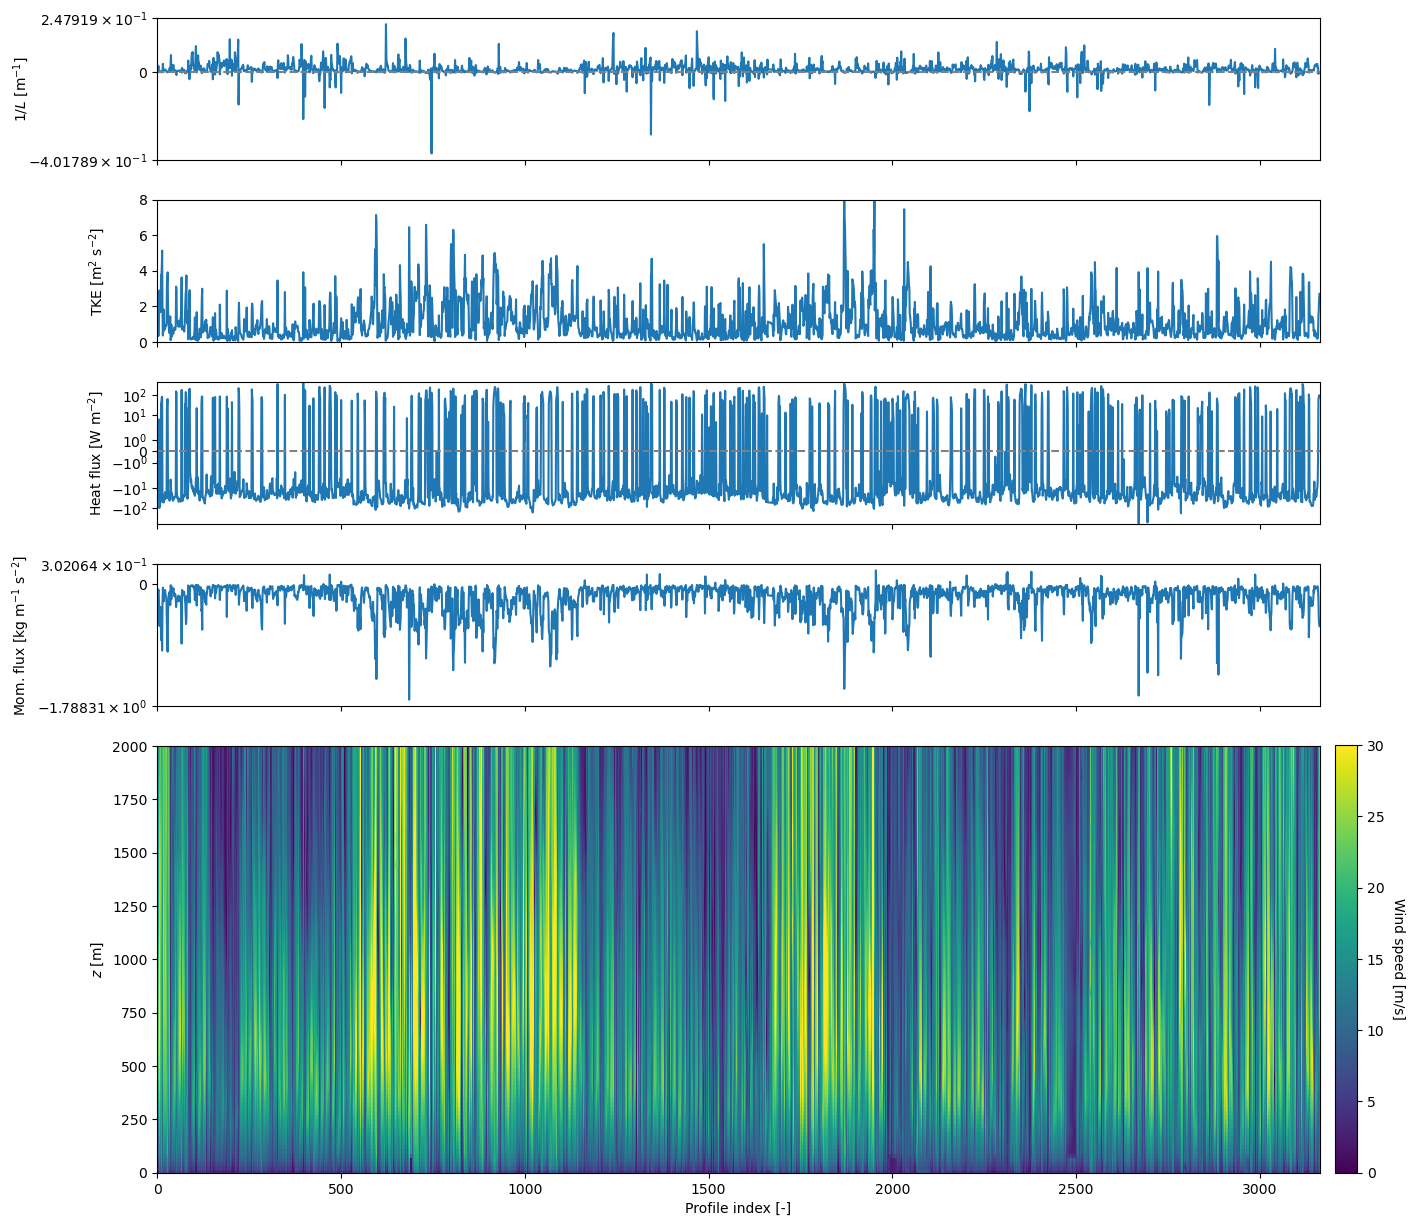

In [12]:
# Plot rectified surface quantities
# --------------------------------------

fig,ax = plt.subplots(5, 1, figsize = (15, 15), gridspec_kw = {'height_ratios': [1, 1, 1, 1, 3]}, sharex = True)

ax[0].plot(range(len(ds_new.time)), ds_new.L)
ax[0].set_ylabel("$1/L$ [m$^{-1}$]", labelpad = -2)
ax[0].axhline(y = 0, color = 'grey', linestyle = '--')
ax[0].set_yscale('symlog')

ax[1].plot(range(len(ds_new.time)), ds_new.TKE)
ax[1].set_ylabel("TKE [m$^2$ s$^{-2}$]", labelpad = 23)
ax[1].set_ylim([0, 8])

ax[2].plot(range(len(ds_new.time)), ds_new.hFlux)
ax[2].set_ylabel("Heat flux [W m$^{-2}$]", labelpad = 3)
ax[2].axhline(y = 0, color = 'grey', linestyle = '--')
ax[2].set_yscale('symlog')

ax[3].plot(range(len(ds_new.time)), ds_new.mFlux)
ax[3].set_ylabel("Mom. flux [kg m$^{-1}$ s$^{-2}$]", labelpad = 4)
ax[3].set_yscale('symlog')

cntf = ax[4].pcolormesh(range(len(ds_new.time)), ds_new.height, (ds_new.v**2 + ds_new.u**2)**(1 / 2), vmin = 0, vmax = 30, cmap = 'viridis')
ax[4].set_xlabel("Profile index [-]")
ax[4].set_ylabel("$z$ [m]", labelpad = 4)
ax[4].set_ylim([0, 2000])

cb_ax = fig.add_axes([0.91, 0.11, 0.015, 0.285])
cbar = fig.colorbar(cntf, orientation = 'vertical', cax = cb_ax)
cbar.set_label('Wind speed [m/s]', rotation = 270, labelpad = 15)

Text(0.5, 1.0, 'Days from reference: 170.0')

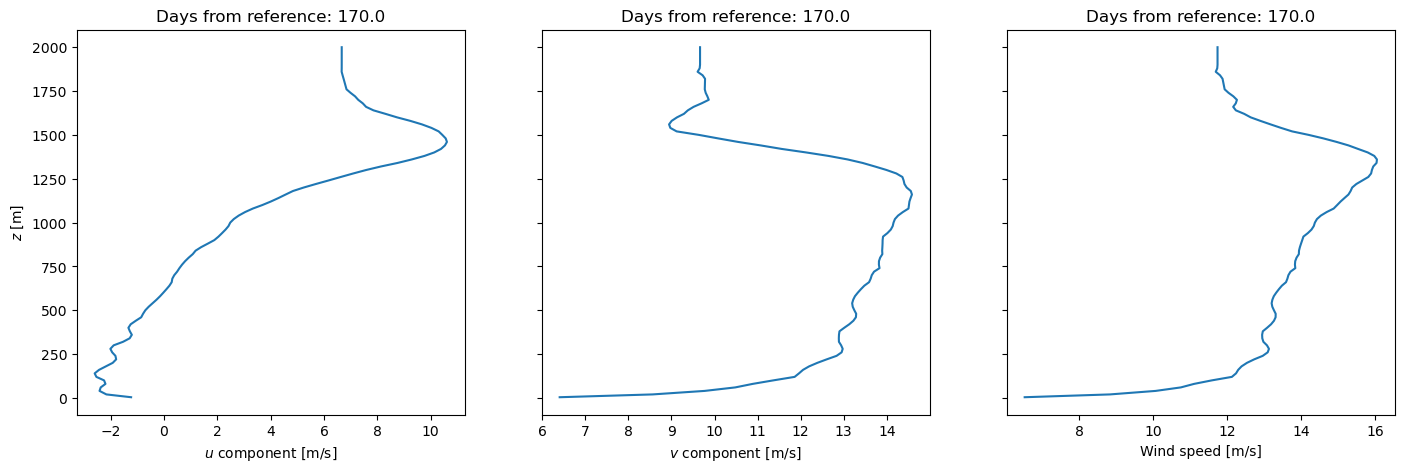

In [20]:
# Plot sample component profiles
# --------------------------------------

fig,ax = plt.subplots(1, 3, figsize = (17, 5), sharey = True)

i = 53

ax[0].plot(ds_new.u[:,i], ds_new.height)
ax[0].set_xlabel('$u$ component [m/s]')
ax[0].set_ylabel('$z$ [m]')
ax[0].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

ax[1].plot(ds_new.v[:,i], ds_new.height)
ax[1].set_xlabel('$v$ component [m/s]')
ax[1].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

ax[2].plot((ds_new.u[:, i]**2 + ds_new.v[:, i]**2)**(1 / 2), ds_new.height)
ax[2].set_xlabel('Wind speed [m/s]')
ax[2].set_title('Days from reference: ' + str(round(float(ds_new.time[i].values), 2)))

In [14]:
# Compute common time axis and cyclical time variables
# --------------------------------------

new_ref_times = np.empty(ds_new.time.shape, dtype = 'datetime64[ns]')
hr_per_day    = np.zeros(new_ref_times.shape)
day_per_yr    = np.zeros(new_ref_times.shape)
times         = ds_new.time.values

for i in range(ds_new.time.shape[0]):
    new_ref_times[i] = np.datetime64((pd.Timestamp(ref_date1) + pd.Timedelta(times[i], 'D')).round('min'))
    hr_per_day[i]    = pd.Timestamp(new_ref_times[i]).hour + pd.Timestamp(new_ref_times[i]).minute / 60
    day_per_yr[i]    = new_ref_times[i].astype('datetime64[D]').astype(datetime).timetuple().tm_yday

Text(0, 0.5, 'Day of year')

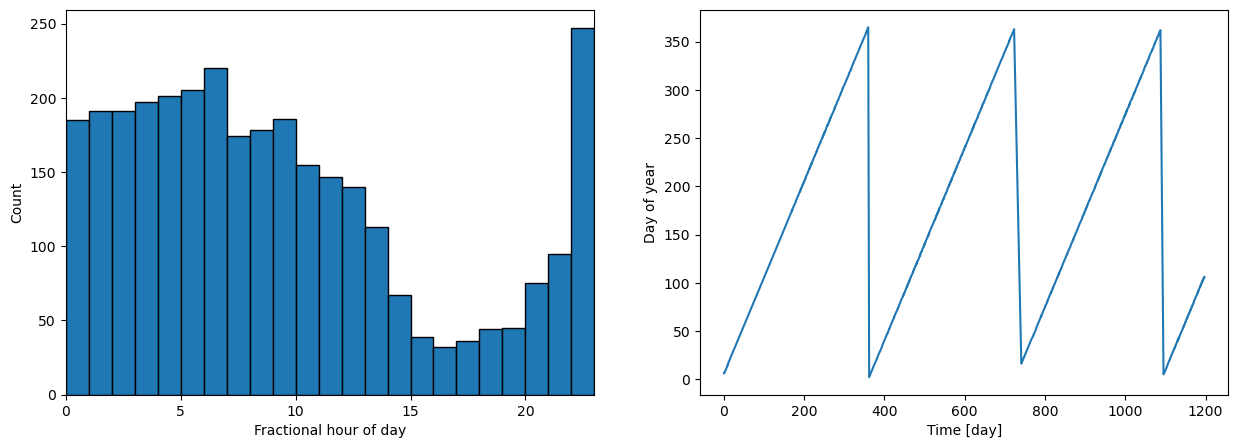

In [15]:
# Confirm time axes are correct
# --------------------------------------

fig,ax = plt.subplots(1, 2, figsize = (15, 5))

ax[0].hist(hr_per_day, bins = 23, edgecolor = 'black')
ax[0].set_xlim([0, 23])
ax[0].set_xlabel('Fractional hour of day')
ax[0].set_ylabel('Count')

ax[1].plot(times, day_per_yr)
ax[1].set_xlabel('Time [day]')
ax[1].set_ylabel('Day of year')

In [16]:
# Save data
# --------------------------------------

ds_new['hr_day'] = (('time'), hr_per_day)
ds_new['day_yr'] = (('time'), day_per_yr)

ds_new.to_netcdf('/Users/smata/Downloads/processedData/velocityData_60min.nc')

ds_new

<xarray.Dataset>
Dimensions:  (height: 102, time: 3163)
Coordinates:
  * height   (height) int64 4 10 20 40 60 80 ... 1900 1920 1940 1960 1980 2000
  * time     (time) float64 1.167 1.208 1.25 ... 1.197e+03 1.197e+03 1.197e+03
Data variables:
    u        (height, time) float64 -2.648 -2.753 -2.627 ... 10.82 7.017 7.163
    v        (height, time) float64 3.67 3.763 3.151 2.164 ... 19.35 21.13 23.13
    L        (time) float64 0.02723 0.02497 0.0156 ... -0.003004 -0.002409
    TKE      (time) float64 0.3693 0.3452 0.4803 0.3422 ... 1.838 2.46 2.712
    hFlux    (time) float64 -31.26 -28.9 -41.19 -25.74 ... 52.68 74.95 95.6 82.7
    mFlux    (time) float64 -0.06733 -0.0682 -0.1199 ... -0.4793 -0.5858 -0.6124
    hr_day   (time) float64 4.0 5.0 6.0 7.0 16.0 ... 13.0 17.0 21.0 22.0 23.0
    day_yr   (time) float64 6.0 6.0 6.0 6.0 6.0 ... 106.0 106.0 106.0 106.0

Text(0, 0.5, 'Count')

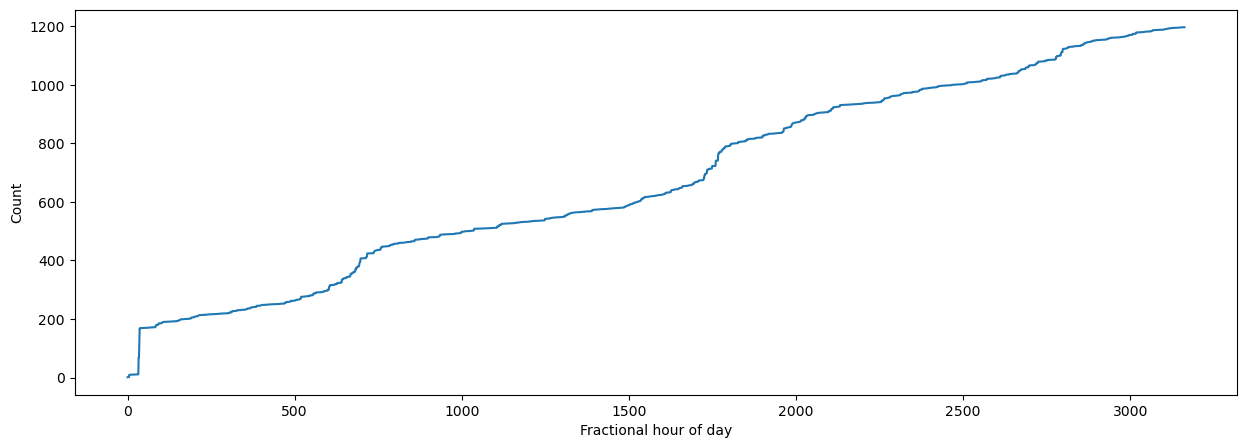

In [17]:
fig,ax = plt.subplots(figsize = (15, 5))

ax.plot(range(len(ds_new.time.values)), ds_new.time.values)
ax.set_xlabel('Profile index [-]')
ax.set_ylabel('Days from regerence [-]')